In [1]:
import os
from wordcloud import WordCloud
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/home/ebrahim/Downloads/spark-3.0.1-bin-hadoop3.2"

In [2]:
import json
import os
import findspark
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
from pyspark.ml.functions import vector_to_array
findspark.init()

In [3]:
# findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Read all profiles

In [4]:
profiles_df = spark.read.parquet('./translated/gsheet/*.parquet').withColumn(
    "translated_description",
    F.regexp_replace(F.col("translated_description"), r"\.|\'|\"|\[|\]|\,|\-|\+|\(|\)|\`|\*|\^", " ")
).withColumn(
    "translated_description",
    F.regexp_replace(F.col("translated_description"), r"\s+", " ")
).withColumn(
    "translated_description",
    F.lower("translated_description"),
).cache()

In [5]:
profiles_df.select(F.col("translated_description"), F.col("id")).show(2)

+----------------------+---+
|translated_description| id|
+----------------------+---+
|   in short i m a p...|  1|
|  lets see i am spi...|  2|
+----------------------+---+
only showing top 2 rows



In [6]:
profiles_df.count()

44263

In [18]:
scam_df = profiles_df.filter(F.col("scam") == 1).filter(F.col("translated_description").isNotNull()).select(F.col("translated_description"))

In [19]:
real_df = profiles_df.filter(F.col("scam") == 0).filter(F.col("translated_description").isNotNull()).select(F.col("translated_description"))

In [20]:
scam_description = [r.translated_description  for r in scam_df.collect()]

In [21]:
real_description = [ r.translated_description for r in real_df.collect()]

In [22]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [23]:
# wordcloud = WordCloud().generate("Hello foo bar")
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "wine", "flavor", "flavors", "love", "Soy", "am"])

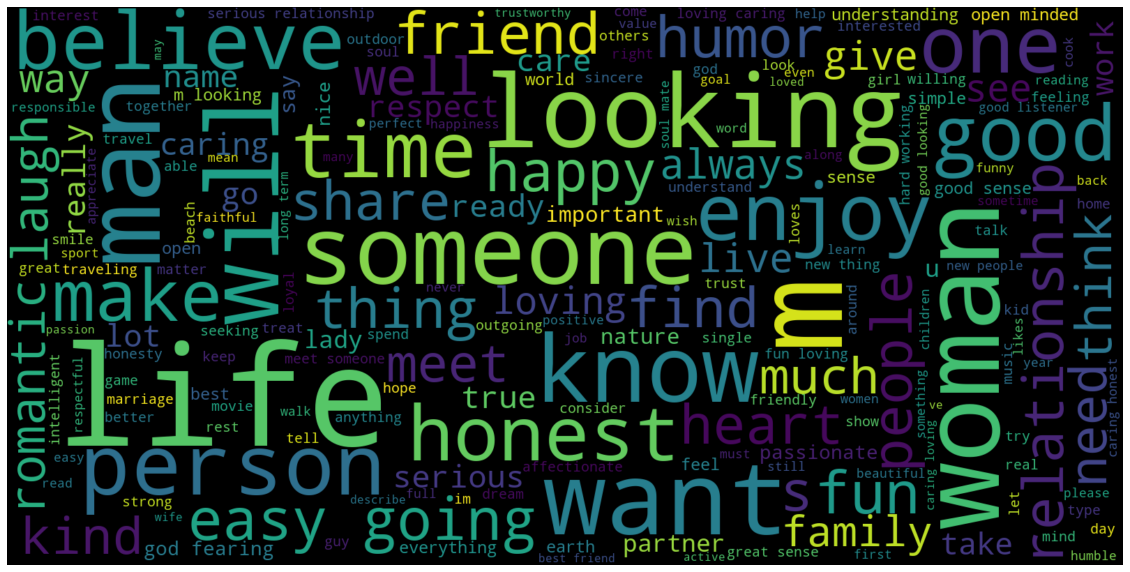

In [24]:
# Generate a word cloud image
# wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate( pd.Series(scam_description).str.cat(sep=' '))
wordcloud = WordCloud(stopwords=stopwords, width=1600, height=800,max_font_size=200).generate(pd.Series(scam_description).str.cat(sep=' '))
plt.figure(figsize=(20,20))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

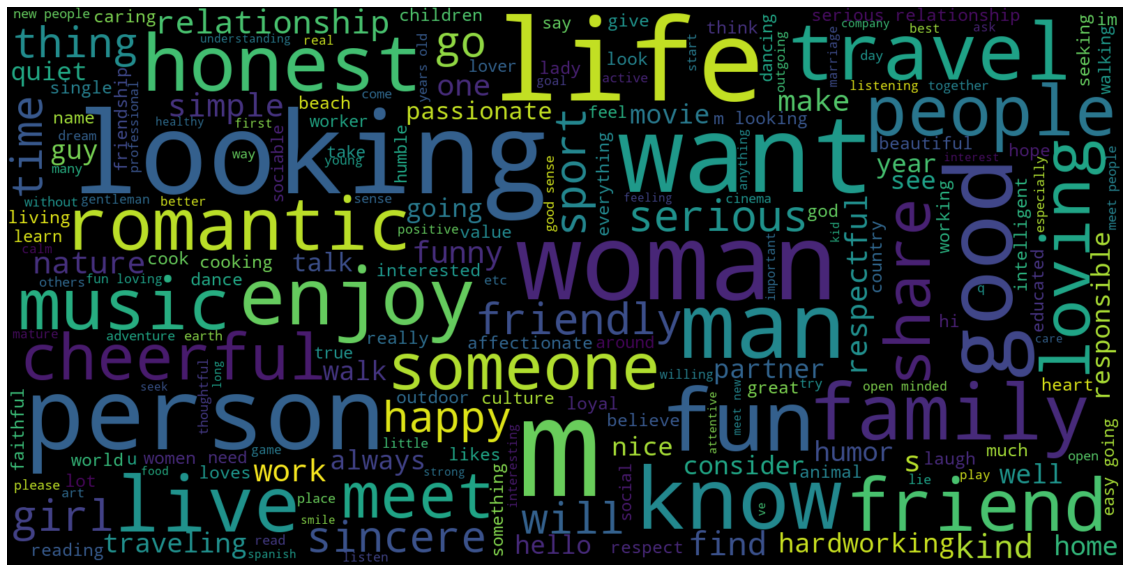

In [25]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, width=1600, height=800,max_font_size=200).generate(pd.Series(real_description).str.cat(sep=' '))
plt.figure(figsize=(20,20))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Count frequencies

In [26]:
description_df = profiles_df.filter(F.col("translated_description").isNotNull()).select(
    F.col("scam"),
    F.col("translated_description").alias("description"),
)

In [27]:
description_df.groupBy("scam").count().show(10)

+----+-----+
|scam|count|
+----+-----+
|   0| 8745|
|   1| 6438|
+----+-----+



In [34]:
tokenizer = Tokenizer(inputCol="description", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
cv = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=50, minDF=2)

pipeline = Pipeline(stages=[tokenizer, remover, cv])

In [35]:
pipelineFit = pipeline.fit(description_df)

In [36]:
vocab = pipelineFit.stages[2].vocabulary

In [37]:
count_v_df = pipelineFit.transform(description_df).withColumn(
    "xs",
    vector_to_array("features"),
).select(
    ["scam"] + [
        F.col("xs")[i].alias(vocab[i])
        for i in range(len(vocab))
    ],
)

In [38]:
agg_word_count_df = count_v_df.groupBy(F.col("scam")).agg(
    {v: "sum" for v in vocab }
).select(
    [F.col("scam")] + [F.col(f"sum({v})").alias(v) for v in vocab]
).cache()

In [39]:
agg_word_count_pdf = count_v_df.groupBy(F.col("scam")).agg(
    {v: "sum" for v in vocab }
).select(
    [F.col("scam")] + [F.col(f"sum({v})").alias(v) for v in vocab]
).toPandas()

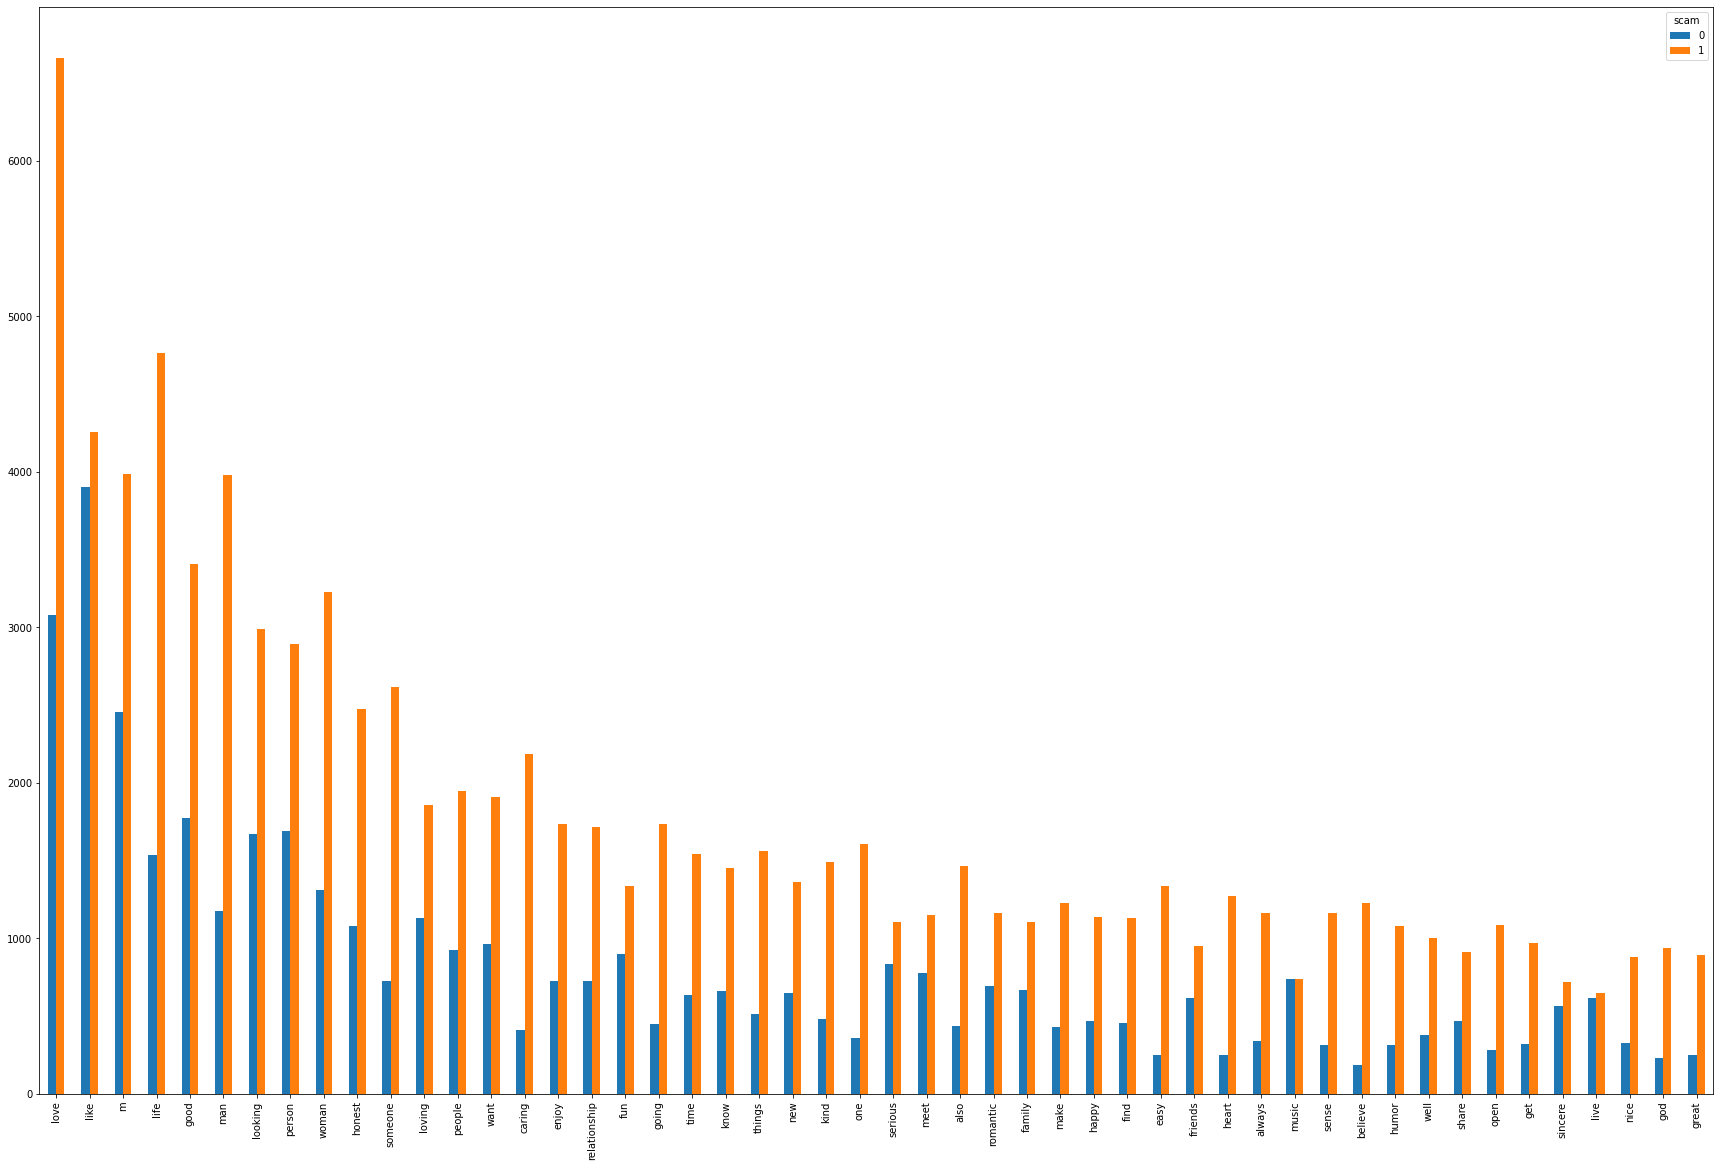

In [40]:
agg_word_count_pdf.set_index(["scam"]).stack().unstack(level=0).plot(
    kind="bar",
#     stacked=True,
    figsize=(30,20),
    subplots=False
)
plt.savefig('./test.png')

In [41]:
spark.stop()